In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import os
import torch
import seaborn as sns
import copy

In [2]:
import sys
sys.path.append('code/BalancingControl')
import tmaze_utils as tu
import misc

Running on device cpu


In [3]:
training_file = os.path.join('raw_data', 'Training.csv')

In [4]:
training_csv = pd.read_csv(training_file, delimiter=';')
print(len(training_csv.columns))

181


In [5]:
# cutting out empty rows
training_csv = training_csv[1:18]

# note that animal 21 was excluded
training_csv = training_csv.drop(14)
print(training_csv.columns)

Index(['Rat Nr.', '1st', '2nd', '3rd', '4th', '5th', 'performance', '1st.1',
       '2nd.1', '3rd.1',
       ...
       '3rd.28', '4th.28', '5th.28', 'performance.28', '1st.29', '2nd.29',
       '3rd.29', '4th.29', '5th.29', 'performance.29'],
      dtype='object', length=181)


In [6]:
training_csv

,Rat Nr.,1st,2nd,3rd,4th,5th,performance,1st.1,2nd.1,3rd.1,...,3rd.28,4th.28,5th.28,performance.28,1st.29,2nd.29,3rd.29,4th.29,5th.29,performance.29
1,24.0,R,Lx,Lx,Lx,Lx,0.0,R,Lx,Lv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,25.0,R,R,R,Lv,Lv,40.0,R,Lv,Lv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,26.0,Lx,R,R,Lv,Lv,40.0,R,Lx,Lv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,27.0,Lx,R,Lv,Lv,Lv,60.0,Lx,Lx,Lv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,32.0,Lv,Lv,Lv,Lv,Lv,100.0,R,Lv,Lv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,33.0,R,R,Lx,Lx,Lx,0.0,LX,LX,LX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,34.0,Lv,R,R,Lv,Lv,60.0,R,LX,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,35.0,R,Lx,Lx,Lv,Lv,40.0,R,R,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,44.0,R,R,R,Lv,R,20.0,R,R,R,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,45.0,Lx,Lx,Lx,Lx,Lx,0.0,R,LX,LX,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# encoding:
# during training
# R = right -> wrong = no reward
# Lx = left, didnt consume reward -> no reward
# Lv = left, consumed reward -> reward
# during testing
# U = unbaited arm, wrong choice
# B = baited arm, correct choice

mapping = {"R": 0, "LX": 1, "LV": 1, "U": 1, "B": 0}

reward_mapping = {"R": 0, "LX": 0, "LV": 2, "B": 2, "U": 0}

# animals 24, 25, 26, 27, 32, 33, 34, 35 are alcohol-cie, and animals 44, 45, 46, 47, 20, 21, 38, 39 are controls

animal_nr = list(training_csv['Rat Nr.'])

groups = {"control": animal_nr[:8], "cie": animal_nr[8:]}

print(groups)

n_animals = len(animal_nr)

{'control': [24.0, 25.0, 26.0, 27.0, 32.0, 33.0, 34.0, 35.0], 'cie': [44.0, 45.0, 46.0, 47.0, 20.0, 38.0, 39.0]}


In [8]:
training_trials = 75
test_trials = 5

total_trials = 2*(training_trials+test_trials)

In [9]:
training_csv[training_csv["Rat Nr."]==animal_nr[2]].iterrows

def convert_letter_actions_to_numbers(df, k):

    actions = np.zeros((total_trials, 1)) - 1
    mask = np.zeros((total_trials,1)).astype(bool)
    observations = np.zeros((total_trials, 2))
    rewards = np.ones((total_trials, 2))

    count = 0
    letter = None
    for entry in np.array(df[df['Rat Nr.'] == k])[0]:
        if type(entry) != str:
            pass
        else:
            if entry.upper() in ["LX", "LV", "R"]:
                pass
            elif entry.upper() in ["B", "U"] and letter in ["LX", "LV", "R"]:
                if count < training_trials:
                    count = training_trials
                else:
                    count = 2*training_trials + test_trials
            letter = entry.upper()
            mask[count] = True
            actions[count] = mapping[letter]
            observations[count,1] = mapping[letter] + 1
            rewards[count,1] = reward_mapping[letter]
            count += 1

    return actions, mask, observations, rewards


def create_group_data(group_name, df):

    group_size = len(groups[group_name])
    data_list = []
    plot_dict = {"animal": np.zeros(total_trials*group_size), "correct": np.zeros(total_trials*group_size), "valid": np.zeros(total_trials*group_size).astype(bool), 
                 "group": [group_name]*total_trials*group_size, "trial": np.zeros(total_trials*group_size), "trial_type": []}

    for i,s in enumerate(groups[group_name]):
        print(s)
        actions, mask, observations, rewards = convert_letter_actions_to_numbers(df, s)
        data_list.append({"subject": torch.tensor([s]), "actions": torch.from_numpy(actions).long(), "observations": torch.from_numpy(observations).long(), 
                          "rewards":torch.from_numpy(rewards).long(), "states": torch.from_numpy(observations).long(), 'valid': torch.from_numpy(mask)})
        plot_dict["animal"][i*total_trials:(i+1)*total_trials] = s
        plot_dict["correct"][i*total_trials:(i+1)*total_trials] = rewards[:,1]//2
        plot_dict["valid"][i*total_trials:(i+1)*total_trials] = mask[...,0]
        plot_dict["trial"][i*total_trials:(i+1)*total_trials] = list(range(total_trials))
        plot_dict["trial_type"] += ["training"]*training_trials+["early test"]*test_trials+["training"]*training_trials+["late test"]*test_trials


    return data_list, plot_dict

In [10]:
group_name = "control"

data_list_control, plot_dict_control = create_group_data(group_name, training_csv)
structured_data_control = tu.restructure_behavioral_data(data_list_control)

base_dir = "processed_data"
fname_data = os.path.join(base_dir, f"TMaze_{group_name}_structured_data.json")
misc.save_file(structured_data_control, fname_data)

24.0
25.0
26.0
27.0
32.0
33.0
34.0
35.0


/home/sarah/src/BayesianSpatialNav/code/BalancingControl/tmaze_utils.py:122: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data_val = torch.cat([torch.tensor(d["valid"]) for d in data], dim=-1)


In [11]:
group_name = "cie"

data_list_cie, plot_dict_cie = create_group_data(group_name, training_csv)
structured_data_cie = tu.restructure_behavioral_data(data_list_cie)

base_dir = "processed_data"
fname_data = os.path.join(base_dir, f"TMaze_{group_name}_structured_data.json")
misc.save_file(structured_data_cie, fname_data)

44.0
45.0
46.0
47.0
20.0
38.0
39.0


In [12]:
plot_dict = {"animal": np.append(plot_dict_control["animal"], plot_dict_cie["animal"]), "correct": np.append(plot_dict_control["correct"], plot_dict_cie["correct"]), 
             "group": plot_dict_control["group"] + plot_dict_cie["group"], "valid": np.append(plot_dict_control["valid"], plot_dict_cie["valid"]),
             "trial": np.append(plot_dict_control["trial"], plot_dict_cie["trial"]), 
             "trial_type": plot_dict_control["trial_type"]+plot_dict_cie["trial_type"]}

In [13]:
plot_df = pd.DataFrame(plot_dict)

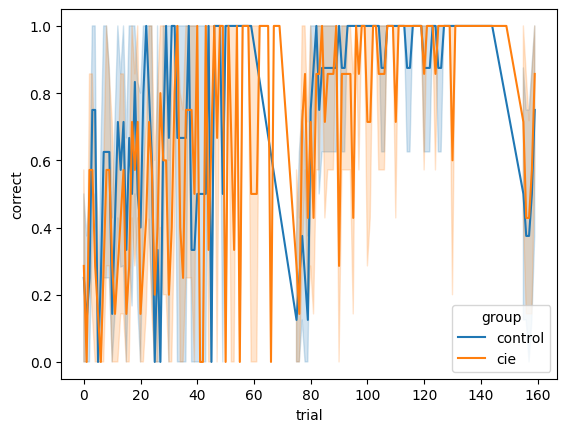

In [14]:
plt.figure()
sns.lineplot(data=plot_df[plot_df["valid"]==True], x="trial", y="correct", hue="group")
plt.show()

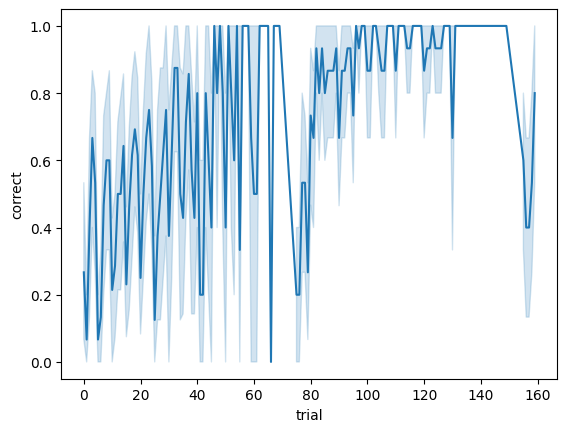

In [15]:
plt.figure()
sns.lineplot(data=plot_df[plot_df["valid"]==True], x="trial", y="correct")
plt.show()